# Last Spring Freeze Prediction for Midwestern Wheat Farming

This notebook was created Bayu Wilson for the purpose of predicting last day of spring freeze (LDSF) for midwestern wheat farmers. Specifically I am using data from a weather measurement station in Wyandotte County, Kansas. This is the same county of a farm that I have previously worked at.

I will be going through a data science project lifecycle in a pedagogical way. [Here's a helpful diagram of the lifecyle](https://www.sudeep.co/data-science/2018/02/09/Understanding-the-Data-Science-Lifecycle.html).

### Business Understanding
See README for details regarding why a midwestern wheat farmer would benefit from a reliable last spring freeze prediction.

### Data Mining

The data in this notebook was ordered from [NOAA's Climate Data Online tool](https://www.ncdc.noaa.gov/cdo-web/search). I selected "Daily Summaries", for dates between 1994 to 2024 in Wyandotte county in Kansas. [Here is the documentation for the dataset](https://www.ncei.noaa.gov/data/daily-summaries/doc/GHCND_documentation.pdf)

These are the main quantities of interest

| Abbreviation | Full Form                         |
|--------------|-----------------------------------|
| DATE         | Date of observation               |
| PRCP         | Precipitation                     |
| TMAX         | Maximum Temperature               |
| TMIN         | Minimum Temperature               |
| TOBS         | Temperature at the Time of Observation |
| SNOW          |  snowfall |
| SNWD          |  snowfall depth  |



### Data Cleaning

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

Here I load the dataset and remove unnecessary columns and stations.

In [2]:
df = pd.read_csv("3809660.csv") # there are a lot of empty columns.
station_list = df["STATION"].unique() #only the sixth station has temperature data
mask = df["STATION"]==station_list[6] #USC00140957, Bonner Springs, KS
df=df[mask]
df["DATE"] = pd.to_datetime(df["DATE"])
useful_columns = ["DATE","TMIN","TMAX","TOBS","PRCP", "SNOW", "SNWD"]
df = df[useful_columns]

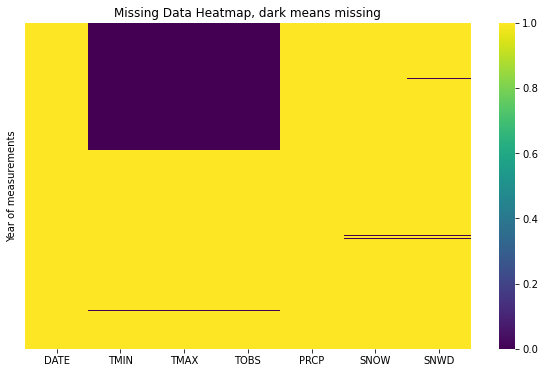

In [3]:
plt.figure(figsize=(10, 6))
sns.heatmap(np.isfinite(df), cbar=True, cmap='viridis', yticklabels=False)
plt.ylabel("Year of measurements")
plt.title("Missing Data Heatmap, dark means missing");

There is clearly a large chunk of missing data. Let's remove those dates.

In [4]:
good_data_idx = df["DATE"][np.isfinite(df["TMIN"])].index[0]
print("data is not NAN for most of the dates after "+str(df["DATE"][good_data_idx]))

data is not NAN for most of the dates after 2004-12-01 00:00:00


In [5]:
assert len(df["DATE"]) == len(np.unique(df["DATE"])) #checking that there are no repeats

In [6]:
df_cleaned = df.loc[good_data_idx:].dropna().reset_index(drop=True)
df_cleaned["year"] = np.asarray(df_cleaned["DATE"].dt.strftime('%Y'),str)
df_cleaned["doy"] = np.asarray(df_cleaned["DATE"].dt.strftime('%j'),int) #doy=day of year
df_cleaned = df_cleaned[df_cleaned["year"] != '2004'] #2004 is missing dates prior to Dec. 1

In [7]:
# df_cleaned #you can check what data frame looks like by uncommenting this

In [8]:
# np.sum(~np.isfinite(df_cleaned[useful_columns])) #no more missing data!

In [9]:
def chunk_data(df): 
    #re-chunk data so that we can easily combine data at the end of one year with
    #the beginning of the next year (the span of the growing season)
    chunks = []
    for year in range(2005, 2021):  # Adjust the range as needed
        start_date = f'{year}-05-21'
        end_date = f'{year + 1}-05-20'
        chunk = df[(df.DATE >= start_date) & (df.DATE < end_date)].copy()
        chunk["year_offset"] = str(year)+"-"+str(year+1)
        chunks.append(chunk)
    return chunks

# Get the chunks
data_chunks = chunk_data(df_cleaned)
df_tot = pd.concat(data_chunks)
df_tot = df_tot[df_tot["doy"] != 366] #I don't care about leap years

Here I am calculating the average minimum temperature over years (2004 to 2021).

In [10]:
doy_temp_stats = df_tot.groupby('doy')['TMIN'].agg(['mean', 'std']).reset_index()
# offset = 365//1.5 #approximately number of days between summer solstice and the end of the year
offset = 225
doy_temp_stats["doy_offset"] = (doy_temp_stats["doy"]+offset)%366-offset
doy_temp_stats = doy_temp_stats.sort_values("doy_offset")

Nbins = 40
df_tot["doy_offset"] = (df_tot["doy"]+offset)%366-offset
bin_edges = pd.cut(df_tot["doy_offset"] , bins=Nbins)
binned_TMIN = df_tot["TMIN"].groupby(bin_edges).mean(numeric_only=True)
binned_TMIN_std = df_tot["TMIN"].groupby(bin_edges).std(numeric_only=True)
bin_centers = bin_edges.cat.categories.mid
# bin_centers = bin_edges[:-1] + (bin_edges[1:] - bin_edges[:-1]) / 2

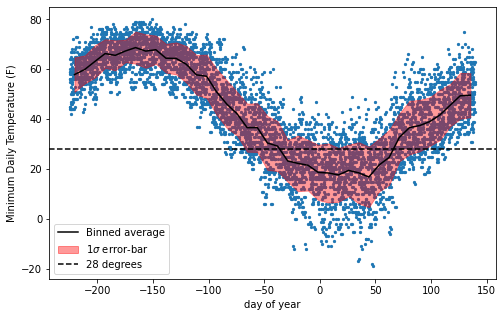

In [11]:
# df_tot["doy_offset"] = doy_offsetted
fig,ax = plt.subplots(1,figsize=(8,5))
plt.scatter(df_tot["doy_offset"],df_tot["TMIN"].values,s=5)
plt.plot(bin_centers,binned_TMIN,color='k',label="Binned average")
plt.fill_between(bin_centers,
                binned_TMIN-binned_TMIN_std,
                binned_TMIN+binned_TMIN_std,
                alpha=0.4,color='red',label=r'$1\sigma$ error-bar')
plt.axhline(28,ls='dashed',color='k',label="28 degrees")
plt.xlabel("day of year")
plt.ylabel("Minimum Daily Temperature (F)");
plt.legend();

Let's make sure that it is reasonable to use standard deviation to quantify the spread. We can check to see if the temperature distributions are gaussian. Below I show the temperature distributions for 4 of the bins.

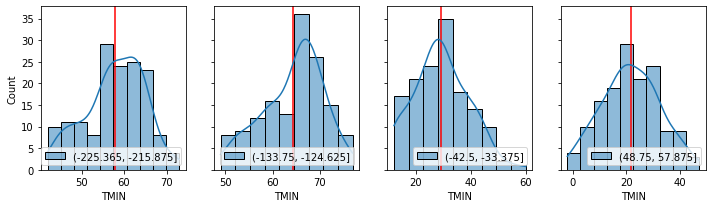

In [12]:
fig,ax = plt.subplots(ncols=4,figsize=(10,3),sharey=True)
for i in range(4):
    index_of_bin = i*10
    gauss_test_bin_edges = np.unique(bin_edges)[index_of_bin]
    gauss_test_TMIN = df_tot["TMIN"][(df_tot["doy_offset"]>gauss_test_bin_edges.left)&(
        df_tot["doy_offset"]<gauss_test_bin_edges.right)]
    mean = np.mean(gauss_test_TMIN)
    ax[i].axvline(mean,color='r')
    sns.histplot(gauss_test_TMIN,kde=True,ax=ax[i],label = str(gauss_test_bin_edges))
    ax[i].legend(loc="lower right")
plt.tight_layout()

That's close enough to gaussian for our purposes.

I am also curious what the typical standard deviations are.

From this we can say that a typical std of TMIN is 11 degrees F.


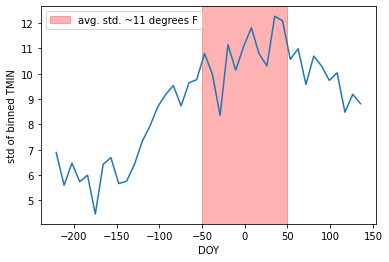

In [13]:
plt.plot(bin_centers,binned_TMIN_std)
plt.xlabel("DOY")
plt.ylabel("std of binned TMIN")
avg_std_TMIN = np.mean(binned_TMIN_std[(bin_centers>-50)&((bin_centers<50))])
plt.axvspan(-50,50,alpha=0.3,color='red',label = f"avg. std. ~{avg_std_TMIN:.0f} degrees F")
plt.legend()
print(f"From this we can say that a typical std of TMIN is {avg_std_TMIN:.0f} degrees F.");

## Solution 1: As simple as it gets
In this first solution, we simply use the average and standard deviation of the minimum temperature to find the last freeze day.

$$  max(\mathrm{DOY}) \ni \mu_{Tmin}-\sigma_{Tmin} \leq 28^\circ \mathrm{F}$$
Note that $\ni$ means "such that". This means that after this DOY, there will be at least an $\approx84\%$ chance that the temperature will be above $28^\circ \mathrm{F}$.

In [14]:
from scipy.interpolate import interp1d
interp_func_value = interp1d(bin_centers, binned_TMIN-binned_TMIN_std, kind='linear')

day_new = np.arange(0,135,1)
pred_last_day = day_new[interp_func_value(day_new)>28][0]
prob = 68/2+50

print(f"There is at least a {prob}% chance that the {pred_last_day}th day of the year "+
      "will have a minimum temperature greater \nthan 28 degrees.")
print("The 96rd day of 2025 is Monday, April 7.")

There is at least a 84.0% chance that the 94th day of the year will have a minimum temperature greater 
than 28 degrees.
The 96rd day of 2025 is Monday, April 7.


### How does this compare to the Farmers' Almanac?

[The Old Farmer's Almanac](https://www.almanac.com/gardening/frostdates/KS/Bonner%20Springs) says Bonner Springs, KS has a 30% chance of a last spring frost (32 degrees) on Apr 23, 2025. If I change the temperature threshold to 32 instead of 28 degrees in this work, the prediction changes to April 17. This is 6 day difference. I am not sure exactly how the almanac did their calculation so I can't comment on why these numbers are different. Note that the almanac uses the same NOAA dataset.

### How does this compare to the actual last freeze days?

The average LDSF is the 97.5th DOY.
The range of LDSF in this dataset is 70 to 115 DOY.


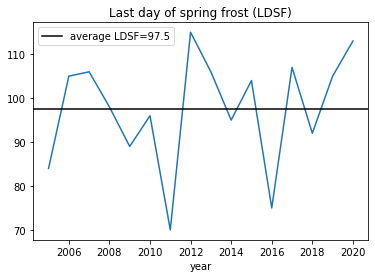

In [15]:
mask = (df_tot["TMIN"]<=28) & (df_tot["doy_offset"]>0)
filtered_df = df_tot[mask] 
yearly_last_frost_by_doy = filtered_df.groupby('year_offset')['doy'].max()
year_offset_list = yearly_last_frost_by_doy.index
year_list = np.asarray([year_offset_list[i][:4] for i in range(len(year_offset_list)) ],int)
simple_LDSF = np.mean(yearly_last_frost_by_doy.values)
plt.plot(year_list,yearly_last_frost_by_doy.values)
plt.axhline(simple_LDSF,color='k',label=f'average LDSF={simple_LDSF}')
plt.xlabel("year")
plt.legend()
plt.title("Last day of spring frost (LDSF)")

earliest_doy, latest_doy = min(yearly_last_frost_by_doy.values), max(yearly_last_frost_by_doy.values)

print(f"The average LDSF is the {simple_LDSF}th DOY.")
print(f"The range of LDSF in this dataset is {earliest_doy} to {latest_doy} DOY.")

Our simple solution predicted that the LDSF is the 96th DOY. This matches well with the actual LDSF calculated from the data. However, it is important to note that this approach does not capture the significant variation in the LDSF, which can span a range of up to 45 days. Clearly it would be useful to have a solution better than this.

## Solution 2: sinusoidal model based off of previous year's trends

The temperatures are obviously periodic and so it would be reasonable to try using a sinusoidal model to forecast the LDSF

In [16]:
import scipy.optimize

def fit_sin(tt, yy):
    '''Fit sin to the input time sequence, and return fitting parameters 
    "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    tt = np.array(tt)
    yy = np.array(yy)
    ff = np.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(np.fft.fft(yy))
    guess_freq = abs(ff[np.argmax(Fyy[1:])+1])   
    # excluding the zero frequency "peak", which is related to offset
    guess_amp = np.std(yy) * 2.**0.5
    guess_offset = np.mean(yy)
    # guess = np.array([guess_amp, 2.*np.pi*guess_freq, 0., guess_offset])
    guess = np.array([guess_amp, 0., guess_offset])

    T = 365 #days
    w=2*np.pi/T
    f = w/(2.*np.pi)
    # def sinfunc(t, A, w, p, c):  
    def sinfunc(t, A, p, c):  
        return A * np.sin(w*t + p) + c
    
    # Perform curve fitting
    popt, pcov = scipy.optimize.curve_fit(sinfunc, tt, yy, p0=guess)
    A, p, c = popt
    
    # calculating uncertainties from covariance matrix
    perr = np.sqrt(np.diag(pcov))
    
    fitfunc = lambda t: A * np.sin(w*t + p) + c
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, #"period": 1./f, 
            "fitfunc": fitfunc, "maxcov": np.max(pcov), "rawres": (guess,popt,pcov)}


For proof of concept, I first try this methodology with the 2007 to 2008 season.

(-100.0, 150.0)

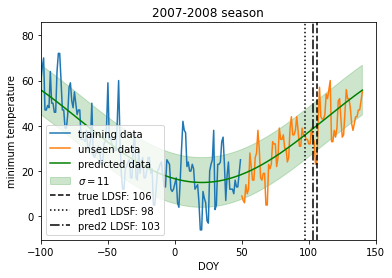

In [17]:
# season_index +=1
season_index=2
mask1 = (df_tot["year_offset"] == year_offset_list[season_index]) 

df_subset = df_tot[mask1].sort_values("doy_offset").copy()
mask2 = (df_subset["doy_offset"]<50)

fit_params = fit_sin(df_subset["doy_offset"].values[mask2],df_subset["TMIN"].values[mask2])
df_subset["fit_TMIN"] = fit_params['fitfunc'](df_subset["doy_offset"])

typical_std_TMIN = 11
pred_LDSF = np.max(df_subset[~mask2][df_subset["fit_TMIN"][~mask2]-typical_std_TMIN<=28]["doy_offset"])

plt.plot(df_subset["doy_offset"][mask2],df_subset["TMIN"][mask2],label="training data")
plt.plot(df_subset["doy_offset"][~mask2],df_subset["TMIN"][~mask2],label="unseen data")
plt.plot(df_subset["doy_offset"],df_subset["fit_TMIN"],label="predicted data",color='green')
plt.fill_between(df_subset["doy_offset"],
                 df_subset["fit_TMIN"]-typical_std_TMIN,
                 df_subset["fit_TMIN"]+typical_std_TMIN,
                 color='green',alpha=0.2,label=r'$\sigma=11$')
plt.xlabel("DOY")
plt.ylabel("minimum temperature")
plt.title(f"{year_offset_list[season_index]} season")

true_LDSF = yearly_last_frost_by_doy[year_offset_list[season_index]]

plt.axvline(true_LDSF,ls='--',color='k',label=f'true LDSF: {true_LDSF:d}')
# plt.axhline(28)
plt.axvline(simple_LDSF,ls='dotted',color='k',label=f'pred1 LDSF: {simple_LDSF:.0f}')
plt.axvline(pred_LDSF,ls='-.',color='k',label=f'pred2 LDSF: {pred_LDSF:d}')
plt.legend(ncols=1,loc="lower left")
plt.xlim(-100,150)
# print(pred_LDSF,true_LDSF, simple_LDSF);

We can quantify how well the predicted value is doing by using the percent difference

In [18]:
perc_diff = np.abs(true_LDSF-pred_LDSF)/(true_LDSF+pred_LDSF)*2*100
day_diff = np.abs(true_LDSF-pred_LDSF)
print(f"percent difference between truth and prediction is ~{perc_diff:.0f}%")
print(f"difference of days between truth and prediction is {day_diff} days")

percent difference between truth and prediction is ~3%
difference of days between truth and prediction is 3 days


### Now repeat this methodology on each season 

I fit a sin function (with fixed, 365 day period) to the data in a single growing season. The idea is that a season might be colder or hotter than an average season. Or perhaps the season's temperature pattern distribution is offset in time by a little bit. 

In [19]:
pred_list = []
true_list = []
for i in range(len(year_offset_list)):
    mask1 = (df_tot["year_offset"] == year_offset_list[i]) 

    df_subset = df_tot[mask1].sort_values("doy_offset").copy()
    mask2 = (df_subset["doy_offset"]<50)

    fit_params = fit_sin(df_subset["doy_offset"].values[mask2],df_subset["TMIN"].values[mask2])
    df_subset["fit_TMIN"] = fit_params['fitfunc'](df_subset["doy_offset"])

    typical_std_TMIN = 11
    pred_LDSF = np.max(df_subset[~mask2][df_subset["fit_TMIN"][~mask2]-typical_std_TMIN<=28]["doy_offset"])
    pred_list.append(pred_LDSF)
    
    true_LDSF = yearly_last_frost_by_doy[year_offset_list[i]]
    true_list.append(true_LDSF)
    # plt.axvline(true_LDSF,color='k')
    # plt.axvline(pred_LDSF)
    # plt.title(year_offset_list[i])
    # plt.plot(df_subset["doy_offset"],df_subset["TMIN"])
    # plt.plot(df_subset["doy_offset"],df_subset["fit_TMIN"])

In [20]:
day_diff_list_m1 = []
day_diff_list_m2 = []
for i in range(len(pred_list)):
    day_diff_list_m1.append((simple_LDSF-true_list[i]))
    day_diff_list_m2.append((pred_list[i]-true_list[i]))

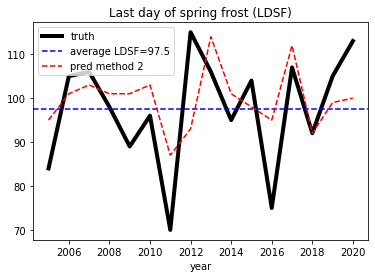

In [21]:
plt.plot(year_list,yearly_last_frost_by_doy.values,label='truth',color='k',lw=4)
plt.axhline(simple_LDSF,label=f'average LDSF={simple_LDSF}',ls='dashed',color='blue')
plt.plot(year_list,pred_list,label='pred method 2',ls='dashed',color='red')
plt.xlabel("year")
plt.legend()
plt.title("Last day of spring frost (LDSF)");

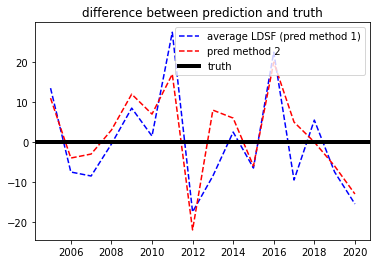

In [22]:
plt.plot(year_list,day_diff_list_m1,ls='dashed',color='blue',label=f'average LDSF (pred method 1)')
plt.plot(year_list,day_diff_list_m2,ls='dashed',color='red',label='pred method 2')
plt.axhline(0,lw=4,color='k',label="truth")
plt.title("difference between prediction and truth")
plt.legend();

In [23]:
avg_day_diff_m1 =  np.mean(np.abs(day_diff_list_m1))
avg_day_diff_m2 =  np.mean(np.abs(day_diff_list_m2))
percent_change = (1-avg_day_diff_m2/avg_day_diff_m1)*100
print("The sinusoidal model decreases the average LDSF residual from "+
      f"{avg_day_diff_m1:.1f} to {avg_day_diff_m2:.1f} days.")
print(f"This is a {percent_change:.1f}% decrease.")

The sinusoidal model decreases the average LDSF residual from 10.2 to 8.9 days.
This is a 12.3% decrease.


A 12% better understanding on the LDSF would be have a significant effect on the agriculture industry as it would better inform farmers on when they should take actions to prevent freeze damage on their crops.

## Solution 3: Univariate traditional time-series models: ARIMA/SARIMA
ARIMA is the autoregressive integrated moving average. It is a statistical analysis model that uses time series data to predict future trends. It is a form of regression analysis. "Autoregressive" means it uses past values to predict future values. "Integrated" means it differences the data to make it stationary (see more about this below). This algorithm uses past forecast errors from the "moving average" to help improve the model. 

ARIMA requires stationary data. This means that statistical properties (like mean, variance, and autocorrelation) remain constant over time. This means that there are no trends, seasonal effects, or other forms of systematic change. Many time-series datasets have trends and seasonal effects but there are ways to transform it to be stationary. One thing that can be done is differencing, detrending, and seasonal adjustment.

SARIMA means "Seasonal ARIMA". It adds a seasonal component which makes it suitable for data with repeating seasonal patterns (such as weather data). One major drawback about it that it adds more hyperparameters whose values are chosen somewhat subjectively and it is computationally expensive. For this simple analysis, it was taking much too long to train the SARIMA with daily frequency data so you will see that I actually decided to use weekly temperature data instead. 

MAJOR CAVEAT: I thinned out the dataset by taking the minimum temperature measurements every 7 days. I should've found the minimum temperature of all days in that week. Since this is just a proof-of-concept, exploratory project and the model takes a non-trivial amount of time to run, I've decided to just leave things as-is.

#### The SARIMA approach

I will use 4 years of weekly temperature data to train the SARIMA model. The model will then be used to forecast the temperatures for around 6 months afterwards. The goal is to predict the last day of spring frost, LDSF, where $T\leq28$ degrees F. In order to quantify its success of this model, I will simply be using the residual between the true and predicted LDSF in units of weeks. 

In [889]:
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

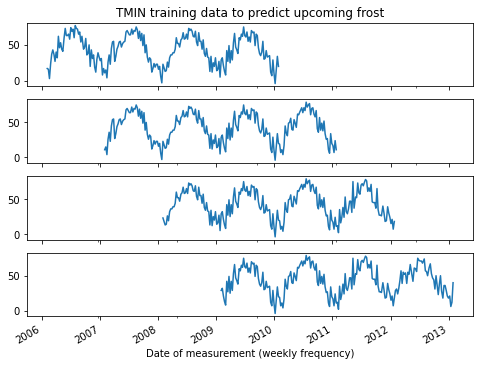

In [892]:
N = len(np.unique(df_tot['year_offset']))
lag_years = 4 #training 4 years beforehand
weekly_df = df_tot.iloc[::7].copy().reset_index(drop=True)
weekly_df.set_index("DATE",inplace=True)
starting_date = pd.to_datetime('2006-01-30')

nrows=4
fig,ax = plt.subplots(nrows=nrows,figsize=(8,6),sharex=True)
for i in range(N-lag_years):
    ending_date = starting_date + pd.Timedelta(days=365*lag_years)
    if i<nrows:
        weekly_df.loc[starting_date:ending_date]["TMIN"].plot(ax=ax[i])
    starting_date += pd.Timedelta(days=365)
ax[0].set_title("TMIN training data to predict upcoming freeze")
ax[-1].set_xlabel("Date of measurement (weekly frequency)");

In [620]:
### BEWARE THIS CELL TAKES A LONG TIME TO RUN ###
starting_date = pd.to_datetime('2006-01-30')
results_list = []
for i in range(N-lag_years):
    ending_date = starting_date + pd.Timedelta(days=365*lag_years)
    data = weekly_df.loc[starting_date:ending_date]["TMIN"]
    model=SARIMAX(data,order=(1,1,1),seasonal_order=(1,1,1,52))
    results=model.fit()
    results_list.append(results)
    starting_date += pd.Timedelta(days=365)

/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.91901D+00    |proj g|=  1.37030D-01

At iterate    5    f=  2.83281D+00    |proj g|=  1.31542D-02

At iterate   10    f=  2.81645D+00    |proj g|=  3.72476D-03

At iterate   15    f=  2.81522D+00    |proj g|=  3.45293D-03

At iterate   20    f=  2.81501D+00    |proj g|=  1.86070D-04

At iterate   25    f=  2.81497D+00    |proj g|=  4.10479D-04

At iterate   30    f=  2.81496D+00    |proj g|=  1.56026D-04

At iterate   35    f=  2.81496D+00    |proj g|=  6.56871D-05

At iterate   40    f=  2.81496D+00    |proj g|=  4.31958D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.95485D+00    |proj g|=  1.95219D-01

At iterate    5    f=  2.85007D+00    |proj g|=  1.50890D-02

At iterate   10    f=  2.82784D+00    |proj g|=  6.01367D-03

At iterate   15    f=  2.82635D+00    |proj g|=  1.24838D-03

At iterate   20    f=  2.82616D+00    |proj g|=  1.40820D-03

At iterate   25    f=  2.82607D+00    |proj g|=  5.94298D-04

At iterate   30    f=  2.82603D+00    |proj g|=  3.28195D-04

At iterate   35    f=  2.82602D+00    |proj g|=  2.47669D-05

At iterate   40    f=  2.82602D+00    |proj g|=  1.71100D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.02847D+00    |proj g|=  2.21313D-01


 This problem is unconstrained.



At iterate    5    f=  2.91371D+00    |proj g|=  2.77067D-02

At iterate   10    f=  2.87599D+00    |proj g|=  1.03439D-02

At iterate   15    f=  2.87427D+00    |proj g|=  2.76166D-03

At iterate   20    f=  2.87402D+00    |proj g|=  9.58802D-04

At iterate   25    f=  2.87398D+00    |proj g|=  5.25598D-04

At iterate   30    f=  2.87396D+00    |proj g|=  5.84797D-04

At iterate   35    f=  2.87395D+00    |proj g|=  1.00842D-04

At iterate   40    f=  2.87395D+00    |proj g|=  3.85458D-05

At iterate   45    f=  2.87395D+00    |proj g|=  5.83278D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     46     49   

/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate    0    f=  3.06068D+00    |proj g|=  2.03008D-01

At iterate    5    f=  2.99232D+00    |proj g|=  1.76374D-02

At iterate   10    f=  2.98139D+00    |proj g|=  1.31644D-02

At iterate   15    f=  2.97825D+00    |proj g|=  1.61954D-03

At iterate   20    f=  2.97780D+00    |proj g|=  1.51271D-03

At iterate   25    f=  2.97770D+00    |proj g|=  8.79895D-04

At iterate   30    f=  2.97768D+00    |proj g|=  2.72394D-04

At iterate   35    f=  2.97767D+00    |proj g|=  2.55065D-04

At iterate   40    f=  2.97767D+00    |proj g|=  9.15553D-05

At iterate   45    f=  2.97767D+00    |proj g|=  2.17554D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.07045D+00    |proj g|=  2.71137D-01


 This problem is unconstrained.



At iterate    5    f=  2.99255D+00    |proj g|=  1.58786D-02

At iterate   10    f=  2.95789D+00    |proj g|=  5.40179D-02

At iterate   15    f=  2.95390D+00    |proj g|=  4.73383D-03

At iterate   20    f=  2.95344D+00    |proj g|=  2.36657D-03

At iterate   25    f=  2.95337D+00    |proj g|=  1.12607D-03

At iterate   30    f=  2.95335D+00    |proj g|=  5.06040D-04

At iterate   35    f=  2.95335D+00    |proj g|=  1.40423D-04

At iterate   40    f=  2.95335D+00    |proj g|=  2.94824D-04

At iterate   45    f=  2.95335D+00    |proj g|=  5.97533D-05


/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.95335D+00    |proj g|=  1.61472D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     58      1     0     0   1.615D-04   2.953D+00
  F =   2.9533459124660175     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate    0    f=  3.07995D+00    |proj g|=  2.53388D-01

At iterate    5    f=  3.00217D+00    |proj g|=  4.39670D-02

At iterate   10    f=  2.97644D+00    |proj g|=  1.43280D-02

At iterate   15    f=  2.97602D+00    |proj g|=  2.57917D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     19      1     0     0   6.111D-06   2.976D+00
  F =   2.9760206251649977     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.09214D+00    |proj g|=  2.49962D-01


 This problem is unconstrained.



At iterate    5    f=  3.01049D+00    |proj g|=  6.05981D-02

At iterate   10    f=  2.95932D+00    |proj g|=  9.19491D-03

At iterate   15    f=  2.95682D+00    |proj g|=  3.10091D-03

At iterate   20    f=  2.95612D+00    |proj g|=  1.61679D-03

At iterate   25    f=  2.95610D+00    |proj g|=  1.73897D-03

At iterate   30    f=  2.95606D+00    |proj g|=  4.32645D-04

At iterate   35    f=  2.95605D+00    |proj g|=  2.31203D-04

At iterate   40    f=  2.95604D+00    |proj g|=  8.11474D-05

At iterate   45    f=  2.95604D+00    |proj g|=  1.25523D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     49     56   

/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.12010D+00    |proj g|=  3.05959D-01

At iterate    5    f=  3.02085D+00    |proj g|=  1.52490D-02

At iterate   10    f=  2.96728D+00    |proj g|=  4.15105D-02

At iterate   15    f=  2.96344D+00    |proj g|=  1.32316D-02

At iterate   20    f=  2.96123D+00    |proj g|=  2.20019D-03

At iterate   25    f=  2.96073D+00    |proj g|=  1.83246D-03

At iterate   30    f=  2.96064D+00    |proj g|=  6.01243D-05

At iterate   35    f=  2.96063D+00    |proj g|=  2.70167D-04

At iterate   40    f=  2.96062D+00    |proj g|=  5.82960D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.08531D+00    |proj g|=  2.39409D-01

At iterate    5    f=  2.98607D+00    |proj g|=  8.11712D-02

At iterate   10    f=  2.96920D+00    |proj g|=  1.70473D-02

At iterate   15    f=  2.96813D+00    |proj g|=  2.42274D-04

At iterate   20    f=  2.96805D+00    |proj g|=  4.93136D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     29      1     0     0   3.272D-07   2.968D+00
  F =   2.9680455515852295     

CONVERG

/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.07125D+00    |proj g|=  2.59204D-01

At iterate    5    f=  2.99474D+00    |proj g|=  1.56574D-02

At iterate   10    f=  2.94306D+00    |proj g|=  1.33171D-02

At iterate   15    f=  2.94248D+00    |proj g|=  5.91318D-03

At iterate   20    f=  2.94214D+00    |proj g|=  2.90039D-03

At iterate   25    f=  2.94210D+00    |proj g|=  2.10291D-04

At iterate   30    f=  2.94209D+00    |proj g|=  6.91278D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.02135D+00    |proj g|=  2.37840D-01

At iterate    5    f=  2.92807D+00    |proj g|=  7.14227D-02

At iterate   10    f=  2.91659D+00    |proj g|=  1.27236D-02

At iterate   15    f=  2.91580D+00    |proj g|=  5.64526D-04

At iterate   20    f=  2.91562D+00    |proj g|=  3.32685D-04

At iterate   25    f=  2.91554D+00    |proj g|=  3.63212D-04

At iterate   30    f=  2.91550D+00    |proj g|=  7.10258D-04

At iterate   35    f=  2.91549D+00    |proj g|=  2.55051D-04

At iterate   40    f=  2.91548D+00    |proj g|=  1.85378D-05

At iterate   45    f=  2.91548D+00    |proj g|=  6.19175D-05


/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.91548D+00    |proj g|=  4.71450D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     66      1     0     0   4.714D-06   2.915D+00
  F =   2.9154837762732346     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/bayuwilson/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.97460D+00    |proj g|=  2.11199D-01


 This problem is unconstrained.



At iterate    5    f=  2.90198D+00    |proj g|=  6.70680D-02

At iterate   10    f=  2.88465D+00    |proj g|=  1.19700D-02

At iterate   15    f=  2.88195D+00    |proj g|=  3.67809D-03

At iterate   20    f=  2.87969D+00    |proj g|=  3.44648D-03

At iterate   25    f=  2.87907D+00    |proj g|=  6.31769D-04

At iterate   30    f=  2.87901D+00    |proj g|=  2.17209D-04

At iterate   35    f=  2.87900D+00    |proj g|=  4.60641D-05

At iterate   40    f=  2.87900D+00    |proj g|=  1.34933D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     42     50      1     0     0   2.971D-05   2.879D+00
  F =   2.87899954460

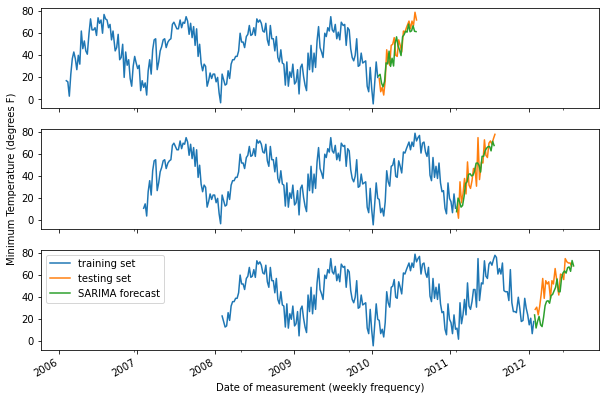

In [896]:
import warnings
warnings.filterwarnings("ignore",
                        message="No supported index is available. Prediction results will be " +
                        "given with an integer index beginning at `start`.")

train_starting_date = pd.to_datetime('2006-01-30')

nrows=3
fig,ax = plt.subplots(nrows=nrows,figsize=(10,7),sharex=True)

LDSF_test_list = []
LDSF_forecast_list = []
dates_forecast_list = []
for i in range(N-lag_years):
    trian_ending_date = train_starting_date + pd.Timedelta(days=365*lag_years)
    test_starting_date = trian_ending_date
    dates_forecast_list.append(test_starting_date)
    test_ending_date = test_starting_date  + pd.Timedelta(weeks=52//2)
    
    train_dates = weekly_df.loc[train_starting_date:trian_ending_date]["TMIN"]
    test_dates = weekly_df.loc[test_starting_date:test_ending_date]["TMIN"]
    
    forecast_dates = pd.date_range(start=test_starting_date, end=test_ending_date, freq='W')
    forecast_vals = results_list[i].forecast(steps=len(forecast_dates))
    
    LDSF_test = test_dates[test_dates<=28].index[-1]
    LDSF_test_list.append(LDSF_test)
    LDSF_forecast = forecast_dates[(forecast_vals<=28)&(forecast_dates<"2021-07-18")][-1]
    LDSF_forecast_list.append(LDSF_forecast)
    #plotting a few (not all)
    if i<nrows:
        train_dates.plot(ax=ax[i],label='training set')
        test_dates.plot(ax=ax[i],label='testing set')
        ax[i].plot(forecast_dates,forecast_vals,label='SARIMA forecast')
    train_starting_date += pd.Timedelta(days=365)
ax[-1].legend(loc='upper left')
ax[1].set_ylabel("Minimum Temperature (degrees F)")
ax[-1].set_xlabel("Date of measurement (weekly frequency)");

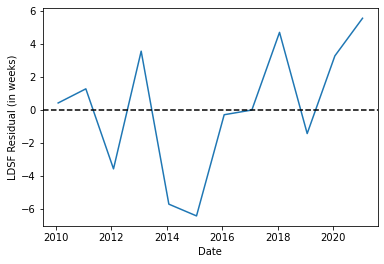

In [897]:
residuals = pd.Series(LDSF_test_list)-pd.Series(LDSF_forecast_list)
residuals = residuals.dt.days
plt.plot(pd.Series(dates_forecast_list),residuals/7)
plt.xlabel("Date")
plt.ylabel("LDSF Residual (in weeks)")
plt.axhline(0,color='k',ls='--')

In [887]:
avg_residual_SARIMA = np.mean(np.abs(residuals))/7
print(f"The average LDSF residual for the SARIMA method is {avg_residual_SARIMA:.0f} weeks")

The average LDSF residual for the SARIMA method is 3 weeks


This is obviously significantly worse than the first two methods. It goes to show that more complex solutions are not always better (especially when the data scientist isn't well versed in SARIMA models!)

## Solution 4: Machine learning models

Here I use the [XGBoost](https://xgboost.readthedocs.io/en/stable/) gradient boosting library. XGBoost stands for "Extreme Gradient Boosting". 

#### Background and notes
Gradient boosted trees have been around for a while but this library is an improvement.  XGBoost is used to solve supervised learning problems. This means that training data (with multiple features) $x_i$ is used to predict a labeled target variable $y_i$. These problems can be divided into regression and classification problems. Classification algorithms are used to group data by predicting a categorical label or output variable based on the input data. Regression algorithms are used to predict a real or continuous value, where the algorithm detects a relationship between two or more variables. 

The model in supervised learning usually refers to the mathematical structure that the prediction $y_i$ is made from the input $x_i$.

XGBoost uses a decision tree ensemble model. A decision tree ensemble consists of a set of classification and regression trees (CART). This is not quite the same from decision trees in which the leaf only contains decision values. In CART, a real score is associated with each of the leaves, which gives us richer interpretations that go beyond classification. (A typical decision tree wouldn't have a score). Also typically, a decision tree model would only emphasize improving impurity (like gini impurity or entropy) but a CART also defines the complexity of the tree. 

In order to train any supervised learning model we need to define an objective function and optimize it.


Tree boosting is a machine learning technique used to improve the performance of decision trees by combining many weak learners (typically shallow decision trees) into a stronger, more accurate model. The most common way to implement tree boosting is with Gradient boosting.

Why is is "extreme"? This is due to several optimizations and enhancements over traditional gradient boosting algorithms. For example, it is more robust because it uses regularization, it is faster/more parallelized and scalable to large datasets. 


In [27]:
# conda install -c conda-forge py-xgboost

In [24]:
#plotting parameters
fontsize=12
lw=1.5
major_tick_size = 5
minor_tick_size = 3
plt.rcParams['font.family'] = "serif"
plt.rcParams['lines.linewidth'] = lw
plt.rcParams['font.size'] = fontsize
plt.rcParams['xtick.major.size'] = major_tick_size
plt.rcParams['xtick.minor.size'] = minor_tick_size
plt.rcParams['ytick.major.size'] = major_tick_size
plt.rcParams['ytick.minor.size'] = minor_tick_size
color_list = ["r","b","g"]
ls_list = ["-","dashed"]

In [25]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from sklearn.multioutput import MultiOutputRegressor

### Useful functions
First I will define useful functions regarding model fitting, time-series smoothing, feature extraction, and LDSF predictions.

In [26]:
# initial_date = pd.Timestamp("2010-01-31")
starting_date_list = [pd.Timestamp(f"{i}-01-31") for i in range(2010,2021,1)]

def get_sin_fit(df,date_today):
    """ fitting tempearture data before 'today' with a sine wave"""
    past_df = df[df.index<date_today]
    fit_params = fit_sin(past_df["doy"],past_df["TMIN"])
    df["T_sin"] = fit_params["fitfunc"](df["doy"])
    return df
    
def smooth_time_series(data, window_size):
    """ rolling average smoothing technique. center=False to prevent data leakage"""
    return pd.Series(data).rolling(window=window_size, center=False).mean()

def add_columns(df):
    """ adding feature and target columns to the dataframe"""
    #features
    df["T_flucs"] = df["TMIN"]/df["T_sin"]-1
    df["month"] = df.index.month
    df["TMIN_trend3"] = smooth_time_series(df["TMIN"],9)-smooth_time_series(df["TMIN"],6)
    df["TMIN_trend2"] = smooth_time_series(df["TMIN"],6)-smooth_time_series(df["TMIN"],3)
    df["TMIN_trend1"] = smooth_time_series(df["TMIN"],3)-smooth_time_series(df["TMIN"],1)
    df["Delta_TMIN"] = df_subset["TMIN"].diff(periods=1)
    df["T_flucs2_roll2"] = smooth_time_series(df["T_flucs"]**2,7)
    df["T_flucs2_roll1"] = smooth_time_series(df["T_flucs"]**2,3)
    df["T_diff"] = df["TMAX"]-df["TMIN"]  
    
    #targets
    df["T_flucs(t+1)"]=df.shift(-1)["T_flucs"]
    df["T_flucs(t+7)"]=df.shift(-7)["T_flucs"]
    df["freeze(t+7)"] = df.shift(-7)["TMIN"]<=28
    df.dropna(inplace=True)
    return df

FEATURES = ["TMIN","doy_offset","T_flucs","month",
            "TMIN_trend3","TMIN_trend2","TMIN_trend1",
            "Delta_TMIN",
            "T_flucs2_roll2","T_flucs2_roll1",
            "T_diff"]
TARGETS = ["T_flucs(t+1)","T_flucs(t+7)","freeze(t+7)"]

def print_MAE(test,preds):
    error_only_sine_t1 = mean_absolute_error(test[TARGETS[0]],preds[TARGETS[0]]*0)
    error_only_sine_t7 = mean_absolute_error(test[TARGETS[1]],preds[TARGETS[1]]*0)
    error_model_flucs_t1 = mean_absolute_error(test[TARGETS[0]],preds[TARGETS[0]])
    error_model_flucs_t7 = mean_absolute_error(test[TARGETS[1]],preds[TARGETS[1]])
    print("Assuming a noiseless sinusoidal model, the MAES are: "+ 
      f"{error_only_sine_t1*100:.0f}% and {error_only_sine_t7*100:.0f}% for a lag of 1 & 7 days respectively.")
    print("Using the XGBoost model, the MAEs are: "+ 
          f"{error_model_flucs_t1*100:.0f}% and {error_model_flucs_t7*100:.0f}% "+
          "for a lag of 1 & 7 days respectively.")
def add_preds(df,preds):
    """ adding prediction columns to the main dataframe"""
    df["TMIN_pred_t1"]=df["T_sin"]*(1+preds[TARGETS[0]])
    df["TMIN_pred_t7"]=df["T_sin"]*(1+preds[TARGETS[1]])
    df["freeze_pred"] = preds[TARGETS[2]]
    return df.dropna()

def get_LDSF(df,feat_name,date_today):
    """ calculating the last day of spring frost """
    mask = (df.index>date_today-pd.Timedelta(days=50))&(df.index<date_today+pd.Timedelta(days=130))
    LDSF = df[mask][df[mask][feat_name]<=28].index[-1]
    return LDSF

Let's take another look at the dataset. Top row is minimum temperature and bottom row is tempearture fluctuations defined to be $$ \delta T_\mathrm{MIN}(t) = \frac{T_\mathrm{MIN}(t)}{T_\mathrm{sine}(t)}-1$$

The sine fit looks good

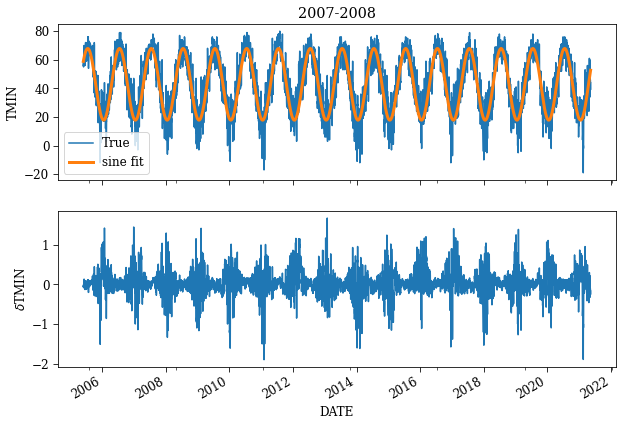

In [27]:
df_subset = df_tot.copy()
df_subset.set_index("DATE",inplace=True)
date_today = starting_date_list[0]
df_subset = get_sin_fit(df_subset,date_today)
df_subset = add_columns(df_subset)

fig,ax=plt.subplots(nrows=2,sharex=True,figsize=(10,7))
ax[0].plot(df_subset.index,df_subset["TMIN"],label='True')
# ax[0].axvline(date_today,label=f"t={date_today.strftime('%m-%d')}",color='k',ls='--')
df_subset["T_sin"].plot(ax=ax[0],label="sine fit",lw=3)
ax[0].legend()
ax[0].set_ylabel("TMIN")
ax[0].set_title(year_offset_list[season_index])
ax[1].set_ylabel(r"$\delta$TMIN")
df_subset["T_flucs"].plot(ax=ax[1]);

### XGBoost regression on a single example
Let's try XGBoost on the just one example for the spring of 2010 

In [28]:
model = xgb.XGBRegressor(n_estimators=1000,
                         objective='reg:squarederror')
model = MultiOutputRegressor(model) #multi-output because I am using 3 target variables

index_today = np.where(df_subset.index==date_today)[0][0]
index_future = index_today+100
train = df_subset.iloc[:index_today]
test = df_subset.iloc[index_today:index_future]
model.fit(train[FEATURES],train[TARGETS])

preds = model.predict(test[FEATURES])
preds = pd.DataFrame(preds,columns=TARGETS,index=test.index)

df_subset = add_preds(df_subset,preds)
print_MAE(test,preds) #mean average errors

Assuming a noiseless sinusoidal model, the MAES are: 27% and 26% for a lag of 1 & 7 days respectively.
Using the XGBoost model, the MAEs are: 20% and 29% for a lag of 1 & 7 days respectively.


It looks like the XGBoost model with a 1 day lag is an improvement over the noiseless sinusoidal model by $7$%. Not bad! What does this look like when we plot this?

LDSF_actual and LDSF_pred(t+1): 2010-03-30 00:00:00: andd 2010-03-27 00:00:00 respectively


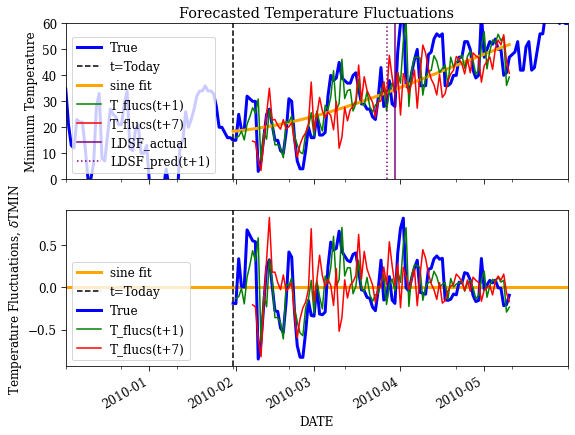

In [29]:
fig,ax=plt.subplots(nrows=2,sharex=True,figsize=(9,7))
ax[0].plot(df_tot['DATE'],df_tot["TMIN"],label='True',lw=3,color='blue')
ax[0].axvline(date_today,label="t=Today",color='k',ls='--')
df_subset["T_sin"].plot(ax=ax[0],label="sine fit",color='orange',lw=3)
df_subset["TMIN_pred_t1"].shift(1).plot(ax=ax[0],label=TARGETS[0],color='green')
df_subset["TMIN_pred_t7"].shift(7).plot(ax=ax[0],label=TARGETS[1],color='red')
ax[0].axvline(get_LDSF(df_subset,"TMIN",date_today),label="LDSF_actual",color='purple')
ax[0].axvline(get_LDSF(df_subset.shift(1).dropna(),"TMIN_pred_t1",date_today),
              label="LDSF_pred(t+1)",color='purple',ls='dotted')
print(f"LDSF_actual and LDSF_pred(t+1): {get_LDSF(df_subset,'TMIN',date_today)}:"+
     f" andd {get_LDSF(df_subset.shift(1).dropna(),'TMIN_pred_t1',date_today)} respectively")
ax[0].set_ylabel("Minimum Temperature")
ax[0].set_ylim(0,60)
ax[0].legend(ncols=1,loc='lower left')
ax[0].set_title("Forecasted Temperature Fluctuations")

ax[1].axhline(0,color='orange',label='sine fit',lw=3)
ax[1].axvline(date_today,label="t=Today",color='k',ls='--')
ax[1].set_ylabel(r"Temperature Fluctuations, $\delta$TMIN")
df_subset["T_flucs"].plot(ax=ax[1],label="True",color='blue',lw=3)
preds[TARGETS[0]].shift(1).plot(label=TARGETS[0],color='green')
preds[TARGETS[1]].shift(7).plot(label=TARGETS[1],color='red')

ax[1].legend(ncols=1,loc='lower left')

ax[1].set_xlim(date_today-pd.Timedelta(days=60),date_today+pd.Timedelta(days=120));

The true minimum temperature distributions are in blue. The model was trained prior to "today" and everything after "today" is forecasted (exept True distribution obviously). There is a lot of noise so it is not surprising that the predictions are not perfect. But since we have prior information of the seasonality (sine function) we can get pretty close. Then our machine learning model can focus on temperature fluctuations rather than the total temperature. 

- `T_flucs(t+1)` is the prediction for temperature fluctuations one day into the future.
- `T_flucs(t+7)` is the prediction for temperature fluctuations seven days into the future.

It looks like our pipeline works alright. The actual and predicted LDSF are only 3 days apart! That's pretty good.


### XGBoost on whole dataset 

Now I will repeat this from 2010 to 2020, calculate the LDSF and then, evaluate the models with mean absolute error.

In [33]:
LDSF_results = []
for i in range(len(starting_date_list)):
    print(f"{i/len(starting_date_list)*100:.0f}% complete.",end='\r')
    df_subset = df_tot.copy()
    df_subset.set_index("DATE",inplace=True)
    date_today = starting_date_list[i]
    df_subset = get_sin_fit(df_subset,date_today)
    df_subset = add_columns(df_subset)

    model = xgb.XGBRegressor(n_estimators=1000,
                             objective='reg:squarederror')
    model = MultiOutputRegressor(model)

    index_today = np.where(df_subset.index==date_today)[0][0]
    index_future = index_today+100
    train = df_subset.iloc[:index_today]
    test = df_subset.iloc[index_today:index_future]
    model.fit(train[FEATURES],train[TARGETS])

    preds = model.predict(test[FEATURES])
    preds = pd.DataFrame(preds,columns=TARGETS,index=test.index)

    # print_MAE(test,preds)

    df_subset = add_preds(df_subset,preds)

    LDSF_true = get_LDSF(df_subset,"TMIN",date_today)
    LDSF_t7 = get_LDSF(df_subset.shift(7).dropna(),"TMIN_pred_t7",date_today)
    LDSF_t1 = get_LDSF(df_subset.shift(1).dropna(),"TMIN_pred_t1",date_today)
    LDSF_bool_freeze = df_subset[df_subset.freeze_pred>0.5].shift(7).dropna().index[-1]
    LDSF_results.append([LDSF_true,LDSF_t1,LDSF_t7,LDSF_bool_freeze])
print("100% complete.")

100% complete.


In [34]:
df_results = pd.DataFrame(LDSF_results,columns=["LDSF_true","LDSF_t1","LDSF_t7","LDSF_bool_freeze"])
df_results = df_results.apply(pd.to_datetime).apply(lambda x:x.dt.dayofyear)
LDSF_t1_MAE = mean_absolute_error(df_results.LDSF_true,df_results.LDSF_t1)
LDSF_t7_MAE = mean_absolute_error(df_results.LDSF_true,df_results.LDSF_t7)
LDSF_bool_freeze = mean_absolute_error(df_results.LDSF_true,df_results.LDSF_bool_freeze)

In [35]:
print("The sinusoidal model decreases the average LDSF residual from "+
      f"{avg_day_diff_m1:.1f} to {avg_day_diff_m2:.1f} days.")
print(f"The XGBoost model with a 1 day lag decreased LDSF MAE to {LDSF_t1_MAE:.1f} days.")
percent_change = (1-LDSF_t1_MAE/avg_day_diff_m1)*100
print(f"This is a {percent_change:.0f}% decrease compared to method 1.")
print(f"Unfortunately the XGBoost model with a 7 day lag increased LDSF MAE to {LDSF_t7_MAE:.1f} days.")
print(f"And the XGBoost classification model with a 7 day lag increased LDSF MAE to {LDSF_bool_freeze:.1f}" +
    " days.")

The sinusoidal model decreases the average LDSF residual from 10.2 to 8.9 days.
The XGBoost model with a 1 day lag decreased LDSF MAE to 7.6 days.
This is a 25% decrease compared to method 1.
Unfortunately the XGBoost model with a 7 day lag increased LDSF MAE to 11.7 days.
And the XGBoost classification model with a 7 day lag increased LDSF MAE to 19.1 days.


In [36]:
from xgboost import plot_importance

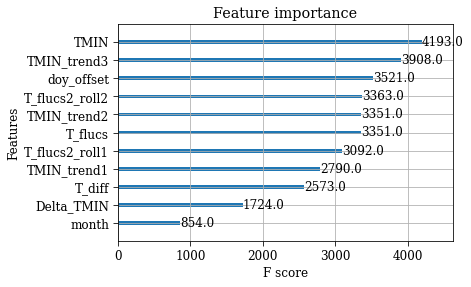

In [50]:
sorted_idx = np.argsort(model.estimators_[0].feature_importances_)[::-1]
plot_importance(model.estimators_[0], max_num_features = 15)
plt.show()